In [112]:
%load_ext autoreload
%autoreload 2
from TPTBox import NII,to_nii
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from einops import rearrange
from omegaconf import OmegaConf
from notebook_helpers import load_model_from_config,visualize_cond_img,get_model
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
t2w_path = "/media/data/robert/datasets/t2w_ct/registration/spinegan0152/target-301_from-201/sub-spinegan0152_ses-20220623_sequ-301_reg-201_e-1_dixon.nii.gz"

nii = to_nii(t2w_path)
nii.rescale_((1,1,1)).reorient_(('R', 'I', 'P'))

shp=(47, 279, 180); ori=('R', 'I', 'P'), zoom=(1.0, 1.0, 1.0), seg=False

In [114]:

path_conf = ("/media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/T2w_2_ct_32x32.yaml")
config = OmegaConf.load(path_conf)
model_d, step = load_model_from_config(
    config,
    "/media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/checkpoints/epoch=000004.ckpt",
    )



Loading model from /media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/checkpoints/epoch=000004.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 131.15 M params.
Keeping EMAs of 522.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


####################################
/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/media/data/anaconda3/envs/ld

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Reload AutoencoderKL:  logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
Restored from logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Reload AutoencoderKL:  logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
Restored from logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt


In [115]:


def get_cond(lr_image_array, hr_image_array):
    example = {}
    # Visualize the condition image (if needed, you can re-implement this function as well)
    visualize_cond_img(lr_image_array,hr_image_array)

    # Process the Low Resolution (LR) image
    c = torch.unsqueeze(torchvision.transforms.ToTensor()(Image.fromarray(lr_image_array)), 0)
    #c = rearrange(c, "1 c h w -> 1 c")
    c = 2.0 * (c/c.max()) - 1.0  # Normalize image

    # Process the High Resolution (HR) image (this assumes the HR image is already provided)
    c_up = torch.unsqueeze(torchvision.transforms.ToTensor()(Image.fromarray(hr_image_array)), 0)
    #c_up = rearrange(c_up, "1 c h w -> 1 h w c")
    # Send to GPU
    c = c.to(torch.device("cuda"))
    c_up = c_up.to(torch.device("cuda"))

    example["c_concat"] = c
    #example["x"] = c_up

    return example


In [118]:
#cond = get_cond(nii.get_array()[10],nii.get_array()[10])

In [119]:
#cond[next(iter(cond.keys()))].shape
def visualize_cond_img(*image_array:torch.Tensor|np.ndarray):
    arrs = []
    for i in image_array:
        i = (i-i.min())/(i.max()-i.min())
        if len(i.shape) == 3:
            i.squeeze_(0)
        arrs.append(i)
    print(i[0].max(),i[0].min())
    i = np.concatenate([*arrs],-1)
    # Display the image array using matplotlib
    plt.figure(figsize=(10, 10*len(image_array)))
    plt.imshow(i,cmap='gray')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

In [122]:
from math import ceil, floor
import torchvision.transforms.functional as tf
from ldm.models.diffusion.ddim import DDIMSampler
from torchvision import transforms
@torch.no_grad()
def convsample_ddim(
    model,
    cond,
    steps,
    eta=1.0,
    callback=None,
    normals_sequence=None,
    mask=None,
    x0=None,
    quantize_x0=False,
    temperature=1.0,
    score_corrector=None,
    corrector_kwargs=None,
    x_T=None,
    padding_mode="constant", # constant, edge, reflect or symmetric
    size=(256,256)
):
    
    target = cond["c_concat"]
    assert target.shape[-3] == 1,target.shape
    # Padding
    w, h = target.shape[-2], target.shape[-1]
    hp = max((size[0]- w) / 2, 0)
    vp = max((size[1]- h) / 2, 0)
    padding = [int(floor(vp)), int(floor(hp)), int(ceil(vp)), int(ceil(hp))]
    target = tf.pad(target, padding, padding_mode=padding_mode)
    #second_img = tf.pad(second_img, padding, padding_mode=self.padding)

    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(target, output_size=size)  # type: ignore
    target = tf.crop(target, i, j, h, w)
    #second_img = tf.crop(second_img, i, j, h, w)
    encoder_posterior = model.encode_first_stage(target)
    c = model.get_first_stage_encoding(encoder_posterior).detach()
    #c = rearrange(c, "1 c h w -> 1 h w c")
    cond2 = {"c_concat": [c]}
    print(cond["c_concat"].shape)
    print(c.shape)
    shape = c.shape
    ddim = DDIMSampler(model)
    bs = shape[0]  # dont know where this comes from but wayne
    shape = shape[1:]  # cut batch dim
    print(f"Sampling with eta = {eta}; steps: {steps}")
    samples, intermediates = ddim.sample(
        steps,
        batch_size=bs,
        shape=shape,
        conditioning=cond2,
        callback=callback,
        normals_sequence=normals_sequence,
        quantize_x0=quantize_x0,
        eta=eta,
        mask=mask,
        x0=x0,
        temperature=temperature,
        verbose=False,
        score_corrector=score_corrector,
        corrector_kwargs=corrector_kwargs,
        x_T=x_T
    )

    return samples, intermediates

#log =convsample_ddim(model_d["model"],cond,20)

In [123]:
#print(log[0].shape,log[1].keys())
#x_sample = model_d["model"].decode_first_stage(log[0])
#print(x_sample.shape)
##print(dataset[0].keys())
#
#visualize_cond_img(x_sample.cpu().reshape(x_sample.shape[-2:]))

In [124]:
from ldm.data.T2w_2_CT import ImageSRValidation,ImageSRTrain
dataset = ImageSRValidation(size=256,image_dropout=0.0,vflip=True,hflip=True,)
dataset_train = ImageSRTrain(size=256,image_dropout=0.0,vflip=True,hflip=True,)

Loaded file list from buffer.
Loaded file list from buffer.


Loaded file list from buffer.
tensor(0.) tensor(0.)


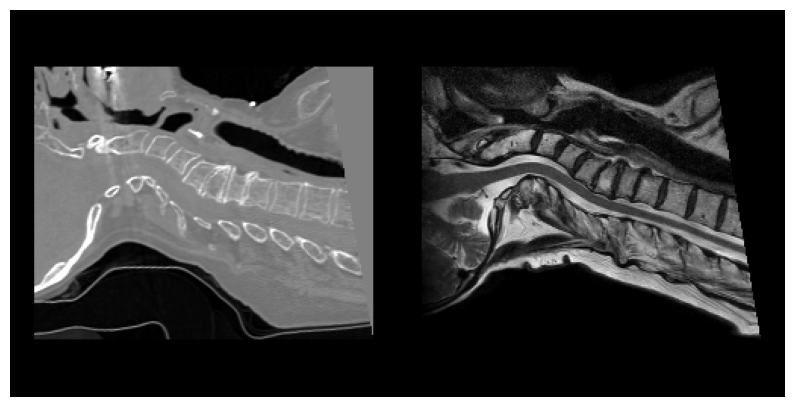

In [125]:
dataset = ImageSRValidation(size=256,image_dropout=0.0,vflip=True,hflip=True,)
d = dataset[0]
visualize_cond_img(d["image"].permute(2,0,1),d["c_concat"].permute(2,0,1))

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 4, 32, 32])
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:06<00:00, 31.71it/s]


torch.Size([1, 1, 256, 256])
tensor(0.0064) tensor(0.0041)


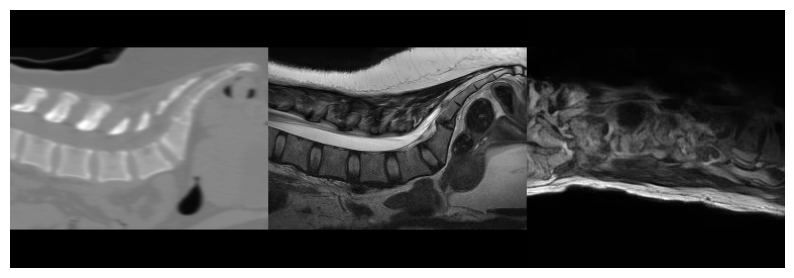

In [131]:
d = dataset[1484] 
inp ={"c_concat": d["image"].cuda().permute((2,0,1)).unsqueeze(0)*0-1}
print(inp["c_concat"].shape)
log =convsample_ddim(model_d["model"],inp,200)
x_sample = model_d["model"].decode_first_stage(log[0])
print(x_sample.shape)
visualize_cond_img(d["image"].permute(2,0,1),d["c_concat"].permute(2,0,1),x_sample.cpu().reshape(x_sample.shape[-2:]))


Loaded file list from buffer.
gauss 1.0
tensor(0.) tensor(0.)


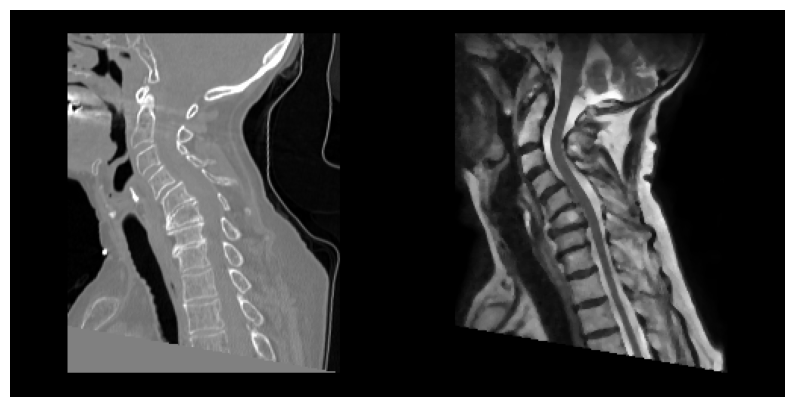

In [110]:
from ldm.data.T2w_2_CT import ImageSRValidation,ImageSRTrain
dataset = ImageSRValidation(size=256,image_dropout= 0.1,vflip= False,hflip= False,dflip=False, rotation= 0,noise_factor=0.1,blur= 0.0,gauss = 1.0,noise=0)
d = dataset[0]
visualize_cond_img(d["image"].permute(2,1,0),d["c_concat"].permute(2,1,0));
